In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random

In [2]:
train_data_p = 'data/train.pkl'
# test not includes `classid` which is only for test
test_data_p = 'data/test.pkl'
train_data = pickle.load(open(train_data_p, 'rb'))
test_data = pickle.load(open(test_data_p, 'rb'))

data shuffling

In [3]:
trainset_ratio = 0.8

# data shufflig
_shuffle = list(zip(train_data['features'], train_data['labels']))
random.shuffle(_shuffle)
features, labels = zip(*_shuffle)
features, labels = np.array(features), np.array(labels, dtype=np.uint8)

train_size = int(len(features)*trainset_ratio)

X_train, y_train = features[:train_size], labels[:train_size]
X_test, y_test = features[train_size:], labels[train_size:]
n_classes = y_train.shape[1]
img_shape = X_train[0].shape

print('Shape of Training image = {}'.format(img_shape))
print('Number of Training = {}'.format(len(y_train)))
print('Number of Testing = {}'.format(len(y_test)))
print('Number of Classes = {}'.format(n_classes))

Shape of Training image = (32, 32, 3)
Number of Training = 31367
Number of Testing = 7842
Number of Classes = 43


Let's random some of train-set images look like.

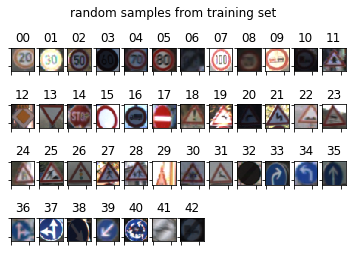

In [4]:
f, ax_array = plt.subplots(4, 12)
plt.suptitle('random samples from training set')
for cls_id, ax in enumerate(ax_array.ravel()):
    if cls_id < n_classes:
        # show random image for current class
        cur_X = X_train[np.where(y_train==1)[1]==cls_id]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(cls_id))
    else:
        ax.axis('off')
# close both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

### (Optional) Histogram of each classes amid train-set and test-set

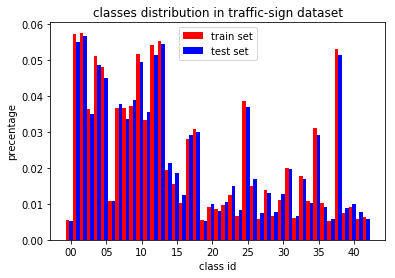

In [5]:
train_distribution, test_distribution = np.zeros(n_classes, dtype=np.float), np.zeros(n_classes, dtype=np.float)

for c in range(n_classes):
    train_distribution[c] = np.sum(np.where(y_train)[1]==c, dtype=np.float32) / len(y_train)
    test_distribution[c] = np.sum(np.where(y_test)[1]==c, dtype=np.float32) / len(y_test)

f, ax = plt.subplots()
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=0.5, color='r')
bar_test = ax.bar(np.arange(n_classes)+0.5, test_distribution, width=0.5, color='b')
ax.set_ylabel('precentage')
ax.set_xlabel('class id')
ax.set_title('classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+0.5)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

### Data augmentation
Following [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) apply YUV color space and then to extract Y-channel color for using mean histogram, global-normalization and local-normalization.
1. mean histogram: moderate poor contrast.
2. global-normalization: centers each image around its mean value.
3. local-normalization: emphasizes edge.

In [6]:
import cv2

def feature_preprocessing(X, eq_hist=True):
    X = np.array([np.expand_dims(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for img in X])
    
    if (eq_hist):
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X], dtype=np.float32)
    
    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)
    
    return X

X_train_norm = feature_preprocessing(X_train)
X_test_norm = feature_preprocessing(X_test)

Second applies image perturbed in position(range of 0.1), scaling(range of 0.2) ratio and rotation (-15,15) degrees.

Using TensorFlow backend.


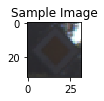

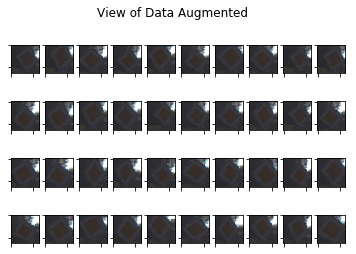

In [7]:
from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
img_demo = X_train[10]
plt.figure(figsize=(1,1))
plt.imshow(img_demo, cmap='gray')
plt.title('Sample Image')
plt.show()

fig, ax_array = plt.subplots(4, 10)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_demo, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([ax.get_xticklabels() for ax in ax_array.ravel()], visible=False)
plt.setp([ax.get_yticklabels() for ax in ax_array.ravel()], visible=False)
plt.suptitle('View of Data Augmented')
plt.show()

### Back to main topic, classification
For now we have training and testing dataset including features and y-label whereby ready for training :D <br/>
In this notebook, we use keras to manipulate tensorflow and only use static features dimension so structure of CNN. 

In [8]:
from keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Activation, Dense
from keras.models import Model

def CNN(input_dim, output_dim):
    inputs = Input(shape=input_dim, name='inputs')
    
    _ = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    _ = MaxPooling2D(pool_size=(2, 2), padding='same')(_)
    _ = Activation('relu')(_)
    
    _ = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')(_)
    _ = MaxPooling2D(pool_size=(2, 2), padding='same')(_)
    _ = Activation('relu')(_)
    
    _ = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(_)
    _ = MaxPooling2D(pool_size=(2, 2), padding='same')(_)
    _ = Activation('relu')(_)
    
    _ = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(_)
    _ = MaxPooling2D(pool_size=(2, 2), padding='same')(_)
    _ = Activation('relu')(_)
    
    _ = Flatten()(_)
    _ = Dense(64, activation='tanh')(_)
    _ = Dense(output_dim, activation='tanh')(_)
    
    outputs = Activation('softmax', name='outputs')(_)
    
    return Model(inputs=inputs, outputs=outputs)

let see this Convolutional Neural Network structure.

In [15]:
cnn = CNN((img_shape[0], img_shape[1], 1), n_classes)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
activation_6 (Activation)    (None, 8, 8, 32)          0         
__________

Set loss function(objective function) and optimised function for model.

In [17]:
from keras.optimizers import SGD
lr = 0.001
optimizer = SGD(lr=lr)
cnn.compile(loss='binary_crossentropy', optimizer=optimizer)

## Now it's show time :D

In [18]:
epochs = 100
batch_size = 128

gen_train = image_datagen.flow(X_train_norm, y_train, batch_size=batch_size)
gen_test = image_datagen.flow(X_test_norm, y_test, batch_size=batch_size)

In [19]:
cnn.fit_generator(generator=gen_train, steps_per_epoch=len(y_train)//batch_size, epochs=epochs, validation_data=gen_test, validation_steps=10)

Epoch 1/100
245/245 [==============================] - 63s 258ms/step - loss: 0.1110 - val_loss: 0.1112
Epoch 2/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1109 - val_loss: 0.1111
Epoch 3/100
245/245 [==============================] - 64s 260ms/step - loss: 0.1108 - val_loss: 0.1111
Epoch 4/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1108 - val_loss: 0.1110
Epoch 5/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1107 - val_loss: 0.1109
Epoch 6/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1106 - val_loss: 0.1109
Epoch 7/100
245/245 [==============================] - 64s 260ms/step - loss: 0.1106 - val_loss: 0.1108
Epoch 8/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1105 - val_loss: 0.1107
Epoch 9/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1104 - val_loss: 0.1107
Epoch 10/100
245/245 [==============================] - 64s 261m

245/245 [==============================] - 64s 260ms/step - loss: 0.1073 - val_loss: 0.1076
Epoch 80/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1072 - val_loss: 0.1076
Epoch 81/100
245/245 [==============================] - 64s 260ms/step - loss: 0.1072 - val_loss: 0.1075
Epoch 82/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1072 - val_loss: 0.1075
Epoch 83/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1071 - val_loss: 0.1074
Epoch 84/100
245/245 [==============================] - 64s 262ms/step - loss: 0.1071 - val_loss: 0.1074
Epoch 85/100
245/245 [==============================] - 64s 262ms/step - loss: 0.1070 - val_loss: 0.1074
Epoch 86/100
245/245 [==============================] - 64s 261ms/step - loss: 0.1071 - val_loss: 0.1074
Epoch 87/100
245/245 [==============================] - 64s 262ms/step - loss: 0.1070 - val_loss: 0.1073
Epoch 88/100
 50/245 [=====>........................] - ETA: 50s - l

KeyboardInterrupt: 